### Setup

In [1]:
import tensorflow as tf

2022-06-02 16:15:16.822830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.__version__

'2.4.1'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-v0gi8uqw
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-v0gi8uqw
  Resolved https://github.com/tensorflow/docs to commit a95a46bd40dd9e37b1ee1b87b57f7efd31a15174


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### データセットを読み込む

MNISTデータセットを使用して、生成器と識別機を学習させる。生成器は、MNISTデータのような手書き数字を生成する。

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-06-02 16:15:34.034138: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-02 16:15:34.035819: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-02 16:15:34.062254: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:34:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-02 16:15:34.062317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:34:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
2022-06-02 16:15:34.062337: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-02 16:15:34.063499: I tensorflow/stream_executor/pla

## モデルを作成する

Keras SequentialAPIから生成器と識別機が定義される。

### 生成器

生成器は`tf.keras.layers.Conv2DTranspose` （アップサンプリング）レイヤーを使用して、ランダムノイズのシードから画像を生成する。そしてDenseレイヤーがこのシードを入力として受け取り、目的の画像サイズである28x28x1に達するまで、数回アップサンプリングする。 tanhを使用する出力レイヤー以外は、各レイヤーを`tf.keras.layers.LeakyReLU`で活性化させる。

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

まだ学習されていない生成器を使って、画像を生成する。

2022-06-02 16:15:36.194565: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-02 16:15:36.692706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-02 16:15:38.631868: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-06-02 16:15:38.799382: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


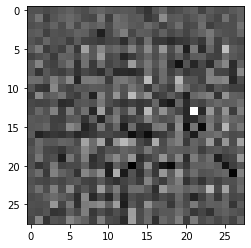

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 識別機

識別機はCNNベースの画像分類器である。

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

まだ学習されていない識別器を使用して、生成された画像が本物かどうかを判定・分類する。モデルは、本物の画像には正の値を出力し、偽物の画像には負の値を出力するように学習される。

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00166704]], shape=(1, 1), dtype=float32)


## 損失関数と最適化手法を定義する

両方のモデルの損失関数と最適化手法を定義する。


In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 識別器の損失関数

識別器が実際の画像と偽物をどれだけうまく区別できるかを定量化する。具体的には、本物の画像での識別器の予測を1の配列と比較し、偽物の画像での識別器の予測を0の配列と比較します。

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 生成器の損失関数

生成器の損失関数は、識別機をだませたかどうか定量化する。具体的には、生成器の性能がいいとき、識別機は偽物の画像を本物（または1）として分類する。ここでは、生成された画像に対する識別機の決定を1の配列と比較する。

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

2つのネットワークを別々に学習させるため、生成器と識別機の最適化手法は違ったものになります。

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### チャックポイントを保存する

このコードでは、モデルを保存および復元する方法も示している。学習タスクが中断されたときに、途中から復元できる。

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 学習ループ


In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

学習ループは、生成器がランダムシードを入力として受け取ることから始まる。そのシードは、画像を生成するために使用される。次に、識別機を使用して、本物の画像（学習セットから抽出）と偽物の画像（生成器が生成）を分類する。損失は​​これらのモデルごとに計算され、勾配は生成器と識別機を更新するために使用されます。

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## モデルを学習させる

上で定義した`train()`メソッドを呼び出して、生成器と識別機を同時に学習させます。 GANの学習では、生成器と識別機が互いに近郊になることが重要です（たとえば、同じ速度で学習するなど）。

学習の開始時に、生成された画像はランダムノイズのように見えます。学習が進むにつれて、生成された数字はますますリアルになります。約50エポックもすれば、生成画像はほぼMNISTの手書き数字のようになります。

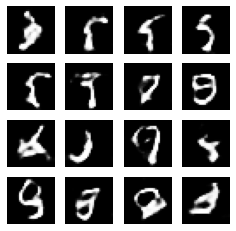

In [22]:
train(train_dataset, EPOCHS)

最新のチェックポイントを復元します。

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIFを作成する


In [24]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

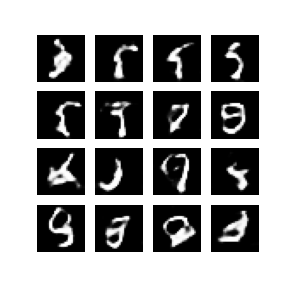

In [25]:
display_image(EPOCHS)

`imageio`を使用して、学習中に保存された画像でGIFを作成します。

In [26]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


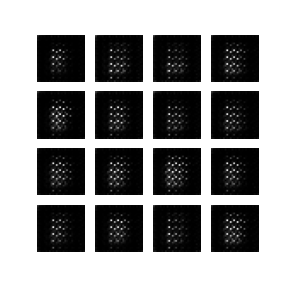

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)